In [1]:
from IPython.display import Image

## Lecture Material: https://drive.google.com/drive/folders/1kzt_ym7MRM4DSxL6ZWlujNzhxWaciFZp?usp=sharing

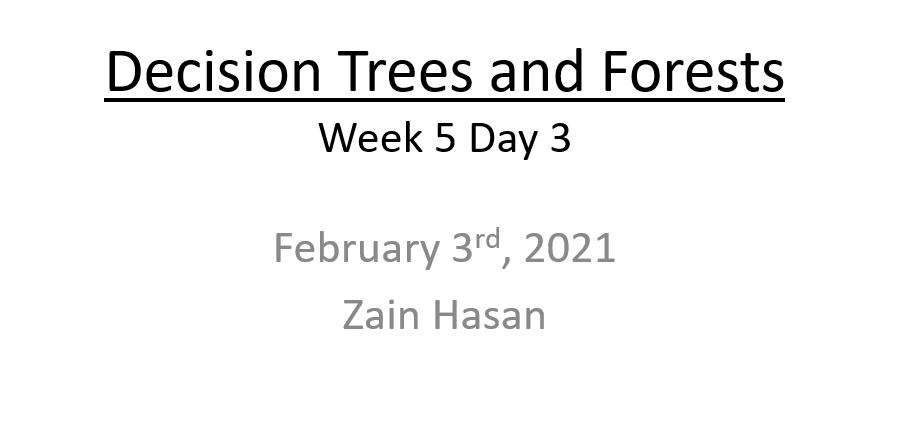

In [2]:
Image(filename='1.PNG')

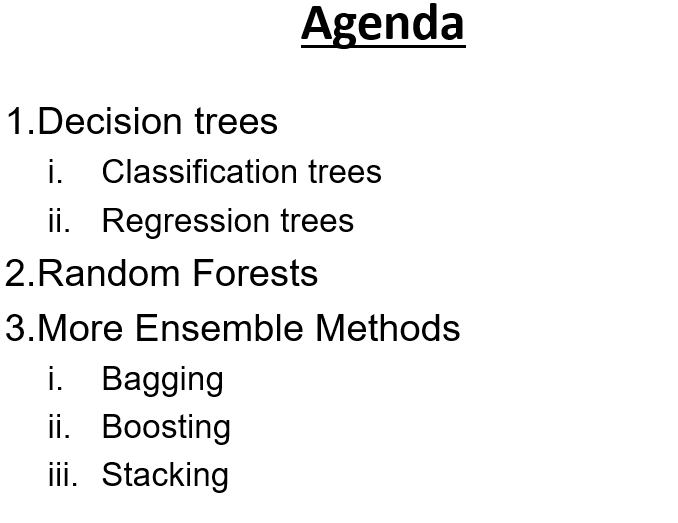

In [3]:
Image(filename='2.PNG')

In [4]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

import warnings
warnings.filterwarnings('ignore')

# Decision Trees

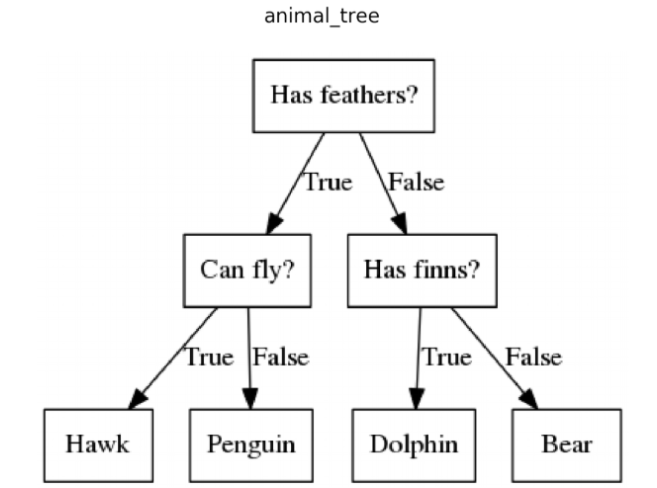

In [5]:
Image(filename='toytree.PNG')

### Some Terminology

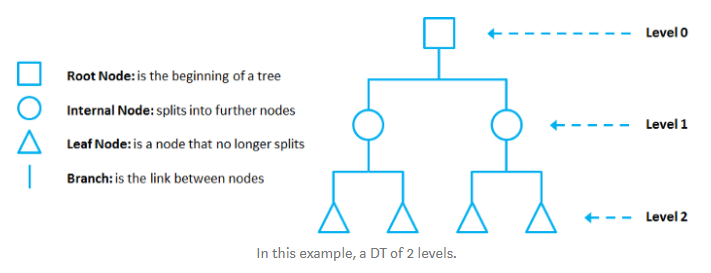

In [6]:
Image(filename='treestructure.PNG')

In [7]:
def plot_tree(X, y, model, predict_proba = False):
    
    # Join data for plotting
    sample = (X.join(y))
    # Create a mesh for plotting
    step = (X.max() - X.min()) / 50
    x1, x2 = np.meshgrid(np.arange(sample.min()[0]-step[0], sample.max()[0]+step[0], step[0]),
                         np.arange(sample.min()[1]-step[1], sample.max()[1]+step[1], step[1]))

    # Store mesh in dataframe
    mesh_df = pd.DataFrame(np.c_[x1.ravel(), x2.ravel()], columns=['x1', 'x2'])

    # Mesh predictions
    if predict_proba:
        mesh_df['predictions'] = model.predict_proba(mesh_df[['x1', 'x2']])[:, 0]
        # Plot
        base_plot = alt.Chart(mesh_df).mark_rect(opacity=0.5).encode(
            x=alt.X('x1', bin=alt.Bin(step=step[0])),
            y=alt.Y('x2', bin=alt.Bin(step=step[1])),
            color=alt.Color('predictions', title='P(blue)', scale=alt.Scale(scheme='redblue'))
        ).properties(
            width=400,
            height=400
        )
        return alt.layer(base_plot).configure_axis(
            labelFontSize=20,
            titleFontSize=20
        ).configure_legend(
            titleFontSize=20,
            labelFontSize=20
        )
    else:
        mesh_df['predictions'] = model.predict(mesh_df[['x1', 'x2']])
        # Plot
        scat_plot = alt.Chart(sample).mark_circle(
            stroke='black',
            opacity=0.5,
            strokeWidth=1.5,
            size=100
        ).encode(
            x=alt.X(X.columns[0], axis=alt.Axis(labels=True, ticks=True, title=X.columns[0])),
            y=alt.Y(X.columns[1], axis=alt.Axis(labels=True, ticks=True, title=X.columns[1])),
            color=alt.Color(y.columns[0])
        )
        base_plot = alt.Chart(mesh_df).mark_rect(opacity=0.5).encode(
            x=alt.X('x1', bin=alt.Bin(step=step[0])),
            y=alt.Y('x2', bin=alt.Bin(step=step[1])),
            color=alt.Color('predictions', title='Legend')
        ).properties(
            width=400,
            height=400
        )
        return alt.layer(base_plot, scat_plot).configure_axis(
            labelFontSize=20,
            titleFontSize=20
        ).configure_legend(
            titleFontSize=20,
            labelFontSize=20
        )

## Let's see how decision trees work
- Get our data in
- Train / validation split
- Fit a **classification tree**

In [8]:
df = pd.read_csv('data/cities_USA.csv', index_col=0)
X = df.drop(columns=['vote'])
y = df[['vote']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
df.head()

,lon,lat,vote
1,-80.162475,25.692104,blue
2,-80.214360,25.944083,blue
3,-80.094133,26.234314,blue
4,-80.248086,26.291902,blue
5,-81.789963,26.348035,blue


In [9]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=None)
model.fit(X_train, y_train)

DecisionTreeClassifier()

## What did the classification tree do?
- Found a good way to split and repeat

In [10]:
plot_tree(X_train, y_train, model)

alt.LayerChart(...)

In [11]:
from sklearn.tree import export_graphviz 
# conda install python-graphviz

import graphviz

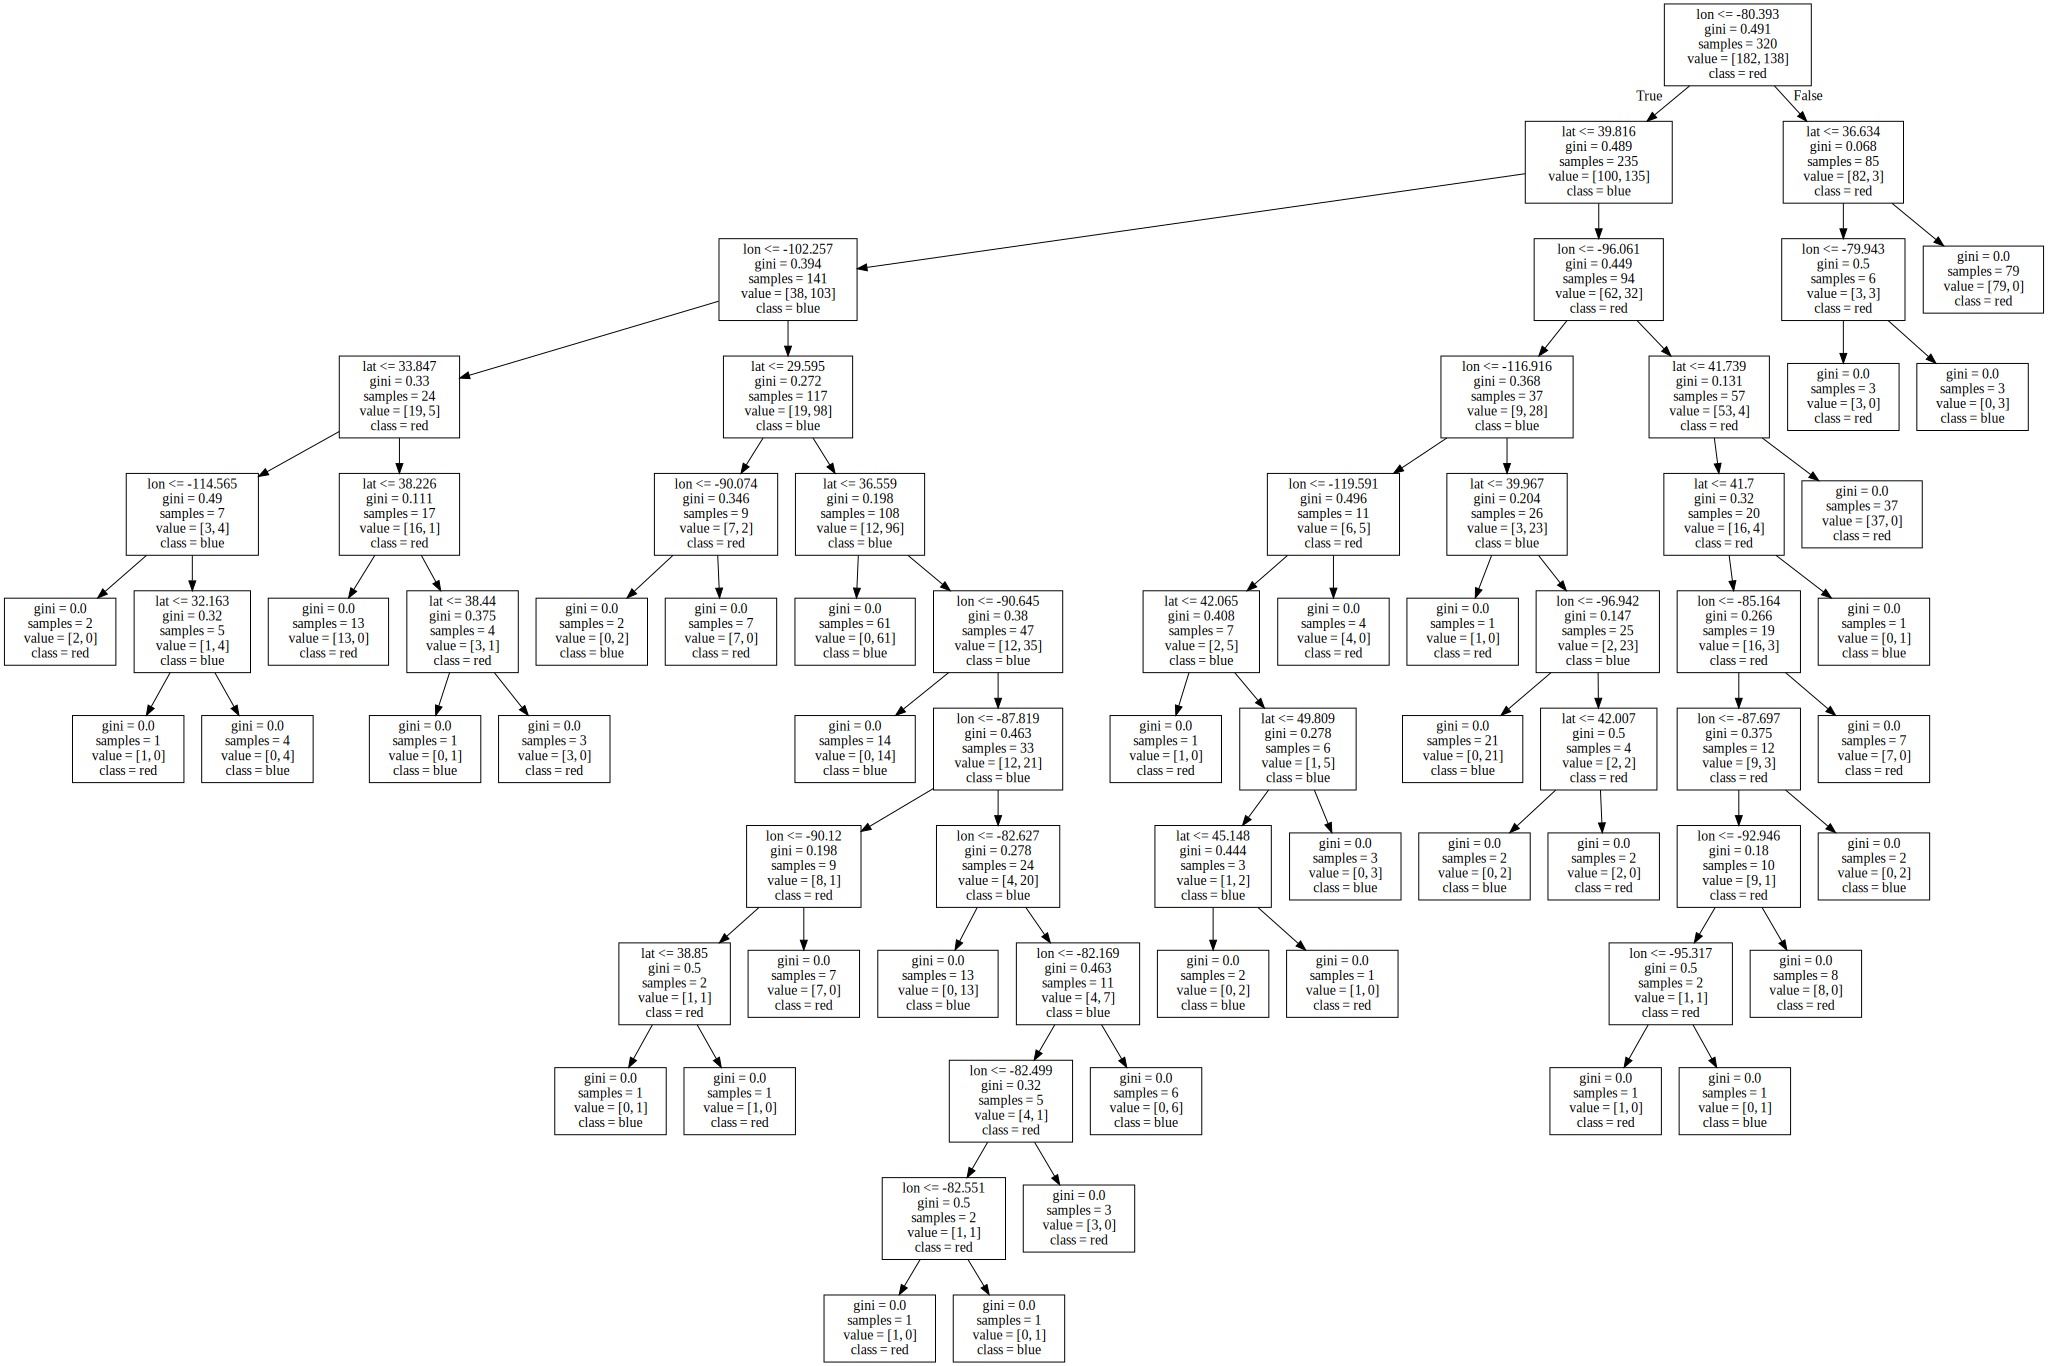

In [12]:
dot_data = export_graphviz(model)
graphviz.Source(export_graphviz(model,
                                out_file=None,
                                feature_names=X.columns,
                                class_names=["red", "blue"],
                                impurity=True))

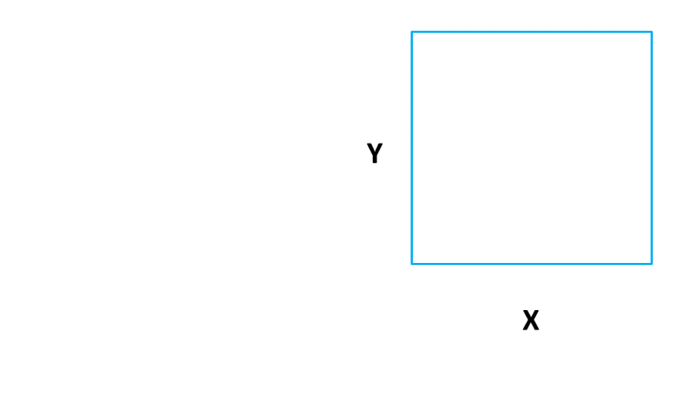

In [13]:
Image(filename='decisionboundaries.gif')

## So how do we decide the split?
- Basic idea is to pick a criterion (see [here](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)) and then minimize it across possible splits.
- Common one is Gini impurity

### Gini Impurity

<img src='imgs/gini.png' width=300>

- $C$ is number of classes in target variable
- $p$ is proportion of class $i$ in a group
- tells us what is the probability of misclassifying an observation --> lower the better


Full details here: https://towardsdatascience.com/gini-impurity-measure-dbd3878ead33

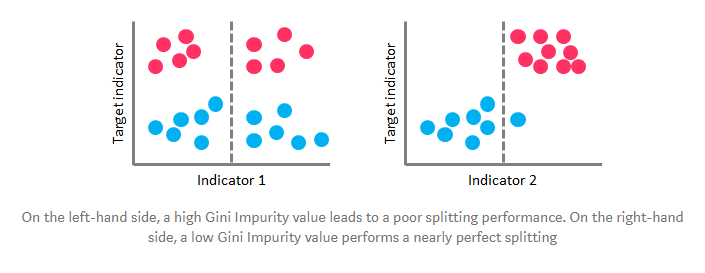

In [14]:
Image(filename='giniimpurity.PNG')

## If code is better for you ...

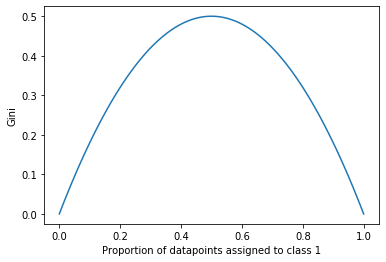

In [15]:
# Gini scoring function for 2 classes
def gini2(c1, c2):
    """
    Calculates the gini impurity for binary class data.

    Parameters
    ----------
    c1 : int
        Number of examples of class 1
    c2 : int
        Number of examples of class 2

    Returns
    -------
    float
        The gini impurity
    """
    n = c1 + c2  # total examples
    p1 = c1 / n  # proportion of instance that are class 1
    p2 = c2 / n  # proportion of instance that are class 2
    return p1*(1-p1) + p2*(1-p2)  # calculate gini impurity


# Gini as a function of %datapoints assigned to class 1
p1s = np.linspace(0, 1, 100)
ginis = 2 * p1s * (1 - p1s)   # Same as gini for 2 classes
fig, ax = plt.subplots()
plt.plot(p1s, ginis)
ax.set_xlabel('Proportion of datapoints assigned to class 1')
ax.set_ylabel('Gini')
plt.show()

## Regression trees
- Less intuitive, but same idea
- Instead of Gini, we use something that works for regression, like MSE (think residuals)
- DTs can only predict within the range of values they created based on the data they saw before, which means that they have boundaries on the values they can produce.

### Example

In [16]:
from sklearn.tree import DecisionTreeRegressor

In [17]:
np.random.seed(333)
df = pd.DataFrame({'feature_1': np.random.randint(0, 10, (6,)),
                   'feature_2': np.random.randint(0, 10, (6,)),
                   'target': np.random.randint(0, 10, (6,))})
df

,feature_1,feature_2,target
0,3,6,5
1,3,4,8
2,6,4,8
3,3,9,7
4,7,7,3
5,7,5,3


## Visualizing the First cut - regression tree

In [18]:
scatter = alt.Chart(df).mark_circle(
    size=150,
    opacity=1,
    stroke='black',
    strokeWidth=1
).encode(
    x=alt.X('feature_1', title='feature_1'),
    y=alt.Y('feature_2', title='feature_2'),
    color='target')
text = scatter.mark_text(
    align='left',
    baseline='middle',
    fontSize = 20,
    dx=8
).encode(
    text='target')
split = alt.Chart(df).mark_rule().encode(
    x='a:Q',
    size=alt.SizeValue(2),
    color=alt.ColorValue("red")
).transform_calculate(
    a="6.5"
)
alt.layer(scatter, text, split).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
    titleFontSize=20,
    labelFontSize=20
).properties(
    width=300,
    height=300
)

alt.LayerChart(...)

## Seeing the first cut in tree format

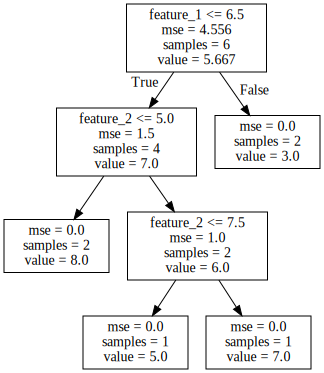

In [19]:
X = df.drop(columns='target')
y = df['target']
model = DecisionTreeRegressor(max_depth=3).fit(X, y)
dot_data = export_graphviz(model)
graphviz.Source(export_graphviz(model,
                                out_file=None,
                                feature_names=X.columns))

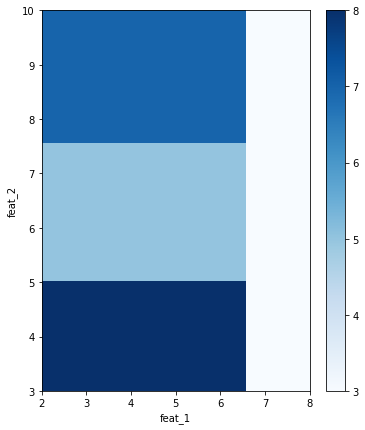

In [42]:
feat1, feat2 = np.meshgrid(np.linspace(2, 8, 60), np.linspace(3, 10, 70))
feat1, feat2 = feat1.flatten(), feat2.flatten()
x = np.stack([feat1, feat2], axis=1)
ypred = model.predict(x)

fig, ax = plt.subplots(figsize=(6, 7))
im = plt.pcolormesh(feat1.reshape(70, 60), feat2.reshape(70, 60), ypred.reshape(70, 60), cmap='Blues')
fig.colorbar(im, ax=ax)
ax.set_xlabel('feat_1')
ax.set_ylabel('feat_2')
plt.show()

## Decision trees, pros and cons
### Advantages:
- Simple to understand and to interpret. Trees can be visualised.
- Requires little data preparation. Doesn't require data normalisation.
- Can handle multi-class classification well.

### Disadvantages:
- Tendency to overfit with overly complex trees that don't generalize well; pruning techniques (e.g., minimum number of samples required at a leaf node, maximum depth of tree) is needed to avoid the problem
- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated; mitigated through ensembles (more on this soon)
- They suffer from an inherent instability, since due to their hierarchical nature, the effect of an error in the top splits propagate down to all of the splits below.
- Is a "greedy" algorithm. Each node is only locally optimal which cannot gaurantee globally optimal tree

## Break

Let's reconvene at 11:05am PT

## Random Forests

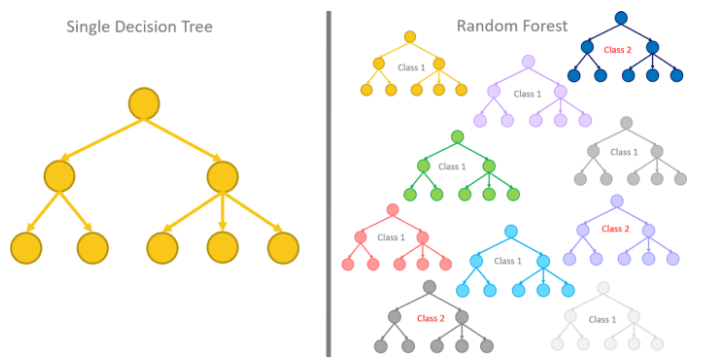

In [21]:
Image(filename='randomforest1.PNG')

### General idea:
   - `fit` a diverse set of classifiers by **injecting randomness** in the classifier construction
   - `predict` by taking the average of predictions given by individual classifiers

### How do we inject randomness in the classifier construction? 
   1. Data: Build each tree on a bootstrap sample (i.e., a sample drawn **with replacement** from the training set)
   2. Features: Consider a random subset of features at each split (`RandomForestClassifier`)
        
**The intuition here is the wisdom of crowds**

### Bootstrapping samples

<img src='bootstrapping.PNG' width='300'>

## The random forest classifier 

- Create a collection (ensemble) of trees. Grow each tree on an independent bootstrap sample from the data.
- At each node:
    - Randomly select a subset of features out of all features (independently for each node)
    - Find the best split on the selected features
    - Grow the trees to maximum depth
- Vote between the trees to get predictions for new data

## Random Forest Training
- Showing feature subset

<img src='imgs/random-forest-features.jpg'>

## Random Forest Prediction
<img src='imgs/random-forest-predict.jpg'>

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
def make_num_tree_plot(X_train, y_train, X_test, y_test, num_trees):
    """
    Make number of trees vs error rate plot for RandomForestClassifier
   
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_test: numpy.ndarray        
        The X part of the test/validation set
    y_test: numpy.ndarray
        The y part of the test/validation set    
    num_trees: int
        The value for `n_estimators` argument of RandomForestClassifier
    Returns
    -------
        None
        Shows the number of trees vs error rate plot
            
    """    
    train_err = []
    test_err = []
    for ntree in num_trees:
        model = RandomForestClassifier(n_estimators=ntree)
        model.fit(X_train, y_train)
        train_err.append(1-model.score(X_train, y_train))
        test_err.append(1-model.score(X_test, y_test))

    plt.semilogx(num_trees,train_err,label="train");
    plt.semilogx(num_trees,test_err,label="test");
    plt.legend();
    plt.xlabel('number of trees');
    plt.ylabel('error rate');

## Beating the fundamental tradeoff...

- Decreasing training error and not increasing test error.
- This is the promise of ensembles, though it's not guaranteed

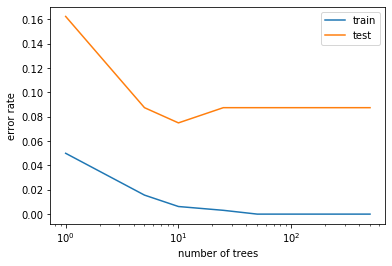

In [24]:
make_num_tree_plot(X_train, np.ravel(y_train), X_val, np.ravel(y_val), (1,5,10,25,50,100,200,500))

## Random Forests summary

- Accuracy
    - Usually more accurate compared to decision trees, usually one of the best performing off-the-shelf classifiers
- Speed
    - Slower than decision trees because we are fitting multiple trees 
    - But can easily parallelize training because all trees are independent of each other - take seperate data and features 
- Overfitting
    - No depth limit decision tree tends to overfit
    - Random forests are less likely to overfit
- Interpretability
    - Decision trees are more interpretable

## Ensembling - why?
- Weak learners (or base models) are models that can be used as building blocks for designing more complex models
- By combining several weak learners together, we can try to reduce bias and/or variance of weak learners
- The ensemble model could have better performance - Kaggle competition winning models are usually ensemble methods

### Some disadvantages:
- Ensembling increases computational time to fit and predict
- Also decreases interpretability

## More Ensemble Methods

### Bagging (Bootstrap and Aggregate)
<img src='bagging.PNG' width='700'>

- Random forest is an example of this
- Same type of weak model used (e.g., trees), models learned in parallel, combines them in a deterministic process (e.g., averaging)


### Boosting (will show example)
<img src='boosting.PNG' width='700'>

- Add one "learner" (i.e. model) at a time, which addresses the "shortcomings" of the current ensemble.
- Unlike averaging, ensemble is created *_during training_*, not after. The process is sequential.
- Example: `AdaBoost`, `XGBoost`, `LGBM`


### Stacking (will show example)
<img src='stacking.PNG' width='700'>

- Usually with heterogeneous (different base model types) models
- Each model learns indepedently and is combined using a voting model


src = https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205

## Load smaller version of data

In [25]:
with open("data/citiesSmall.pkl", "rb") as f:
    data = pickle.load(f)
X_train = data['X']
y_train = data['y']

X_val = data['Xtest']
y_val = data['ytest']

## Boosting - one example library
- `AdaBoost`: Adaptive Boosting

<img src='adaboost.PNG'>

## Demo

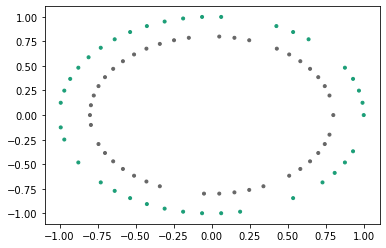

In [26]:
# Let's generate some fake data

# generate blobs with fixed random generator
n = 100
n_classes = 2
X, y = make_circles(n_samples=n, random_state = 122)

X_train_circ, X_test_circ, y_train_circ, y_test_circ = train_test_split(X, y, test_size=0.2)

# How does the data look like? 
plt.scatter(*X_train_circ.T, c=y_train_circ, marker='.', cmap='Dark2');

In [27]:
from sklearn.ensemble import AdaBoostClassifier

In [28]:
ensemble = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators = 4)
ensemble.fit(X_train_circ, y_train_circ);

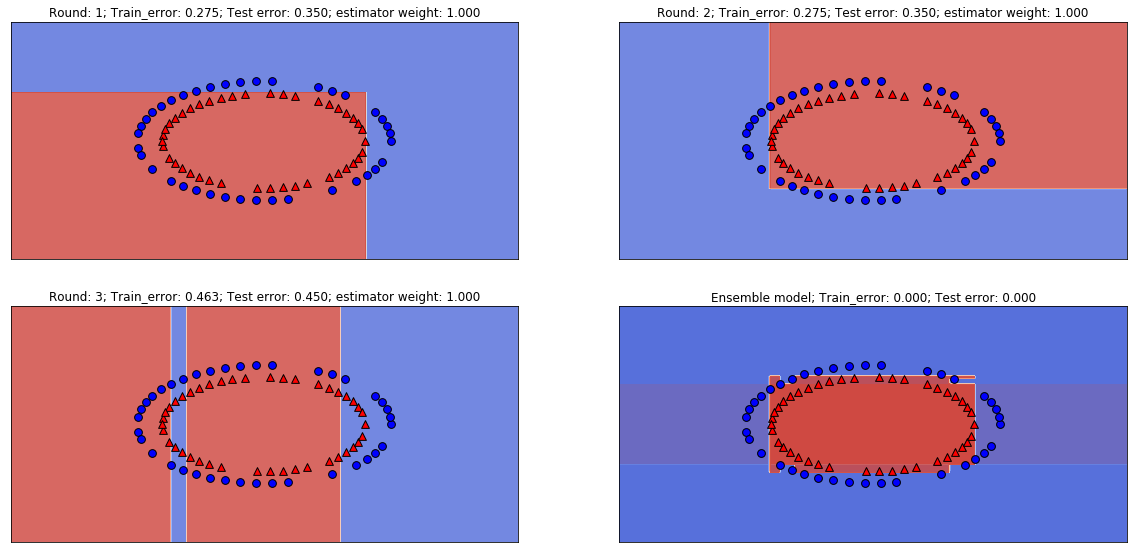

In [29]:
# Combine weak learners 
plt.figure(figsize=(20,20))
count = 0
weights = ensemble.estimator_weights_
for estimator in ensemble.estimators_: # needs scikit-learn-0.20
    plt.subplot(4,2,count+1)
    plot_classifier(X_train_circ, y_train_circ, estimator, ax=plt.gca());
    tr_err = (1 - estimator.score(X_train_circ, y_train_circ))
    te_err = (1 - estimator.score(X_test_circ, y_test_circ))
    title = 'Round: %i; Train_error: %0.3f; Test error: %0.3f; estimator weight: %0.3f'%(count+1, tr_err, te_err, weights[count])
    #title = 'Round: ' + str(count) + '; Train error = ' + str(tr_err) + 'weight: ' + estimator_weights_ 
    plt.title(title);
    count += 1
    
tr_err = (1 - ensemble.score(X_train_circ, y_train_circ))
te_err = (1 - ensemble.score(X_test_circ, y_test_circ))
title = 'Ensemble model; Train_error: %0.3f; Test error: %0.3f'%(tr_err, te_err)
plt.subplot(4,2,count)
plt.title(title)
plot_classifier(X_train_circ, y_train_circ, ensemble, ax=plt.gca());        

## Stacking - code

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier  #meta model

In [31]:
# Create a simple voting classifier using scikit-learn's VotingClassifier

classifiers = {
    "Decision tree"         : DecisionTreeClassifier(max_depth=5),
    "KNN"                   : KNeighborsClassifier(),
    "Naive Bayes"           : GaussianNB(),
    "Logistic Regression"   : LogisticRegression(),
}


ensemble = VotingClassifier(classifiers.items(), voting="soft")

# note: sklearn doesn't seem to support passing pre-trained classifiers into VotingClassifier
ensemble.fit(X_train, np.ravel(y_train));

print('Ensemble performance: \n')
print("Training error:   %.2f" % (1-ensemble.score(X_train, np.ravel(y_train))))
print("Validation error: %.2f" % (1-ensemble.score(X_val, np.ravel(y_val))))

Ensemble performance: 

Training error:   0.05
Validation error: 0.09


In [32]:
## What's the performance of individual classifiers in the ensemble?
for name, estimator in ensemble.named_estimators_.items(): # needs scikit-learn-0.20
    tr_err = (1 - estimator.score(X_train, np.ravel(y_train)))
    te_err = (1 - estimator.score(X_val, np.ravel(y_val)))
    print('%s: Train_error: %0.3f; Test error: %0.3f'%(name, tr_err, te_err))

Decision tree: Train_error: 0.065; Test error: 0.123
KNN: Train_error: 0.042; Test error: 0.069
Naive Bayes: Train_error: 0.338; Test error: 0.367
Logistic Regression: Train_error: 0.307; Test error: 0.333


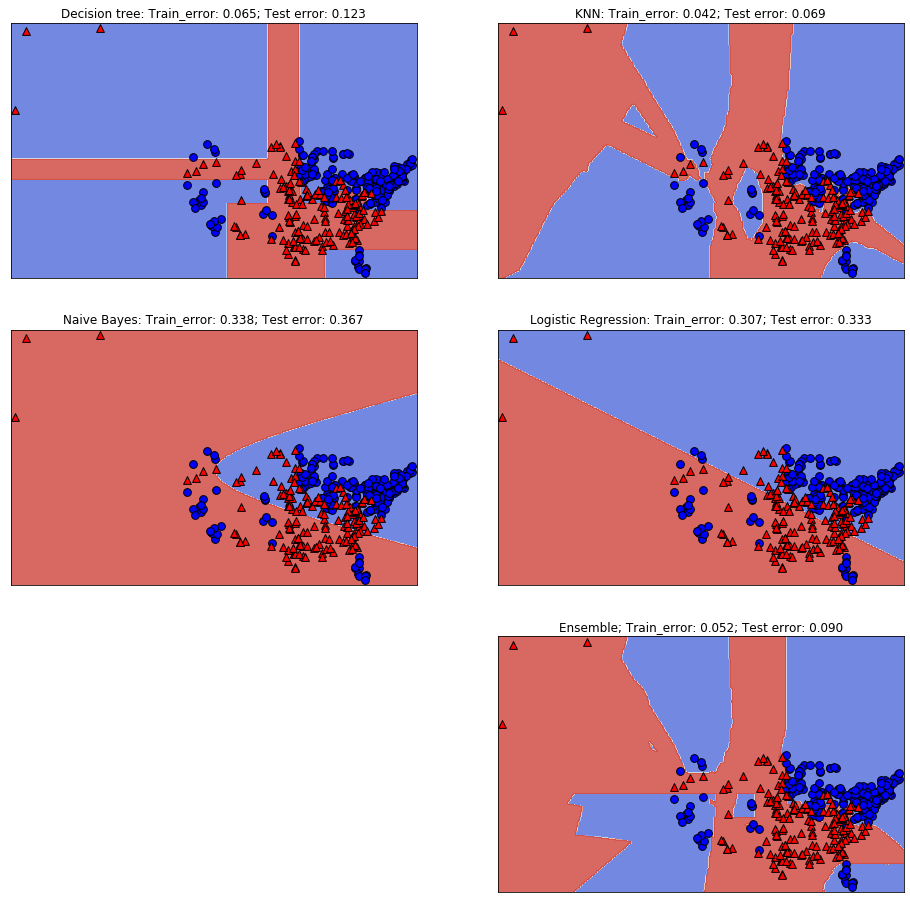

In [33]:
plt.figure(figsize=(16,16))
count = 1
for name, estimator in ensemble.named_estimators_.items(): # needs scikit-learn-0.20
    plt.subplot(3,2,count)
    plot_classifier(X_train, y_train, estimator, ax=plt.gca());
    tr_err = (1 - estimator.score(X_train, y_train))
    te_err = (1 - estimator.score(X_val, y_val))
    title = '%s: Train_error: %0.3f; Test error: %0.3f'%(name, tr_err, te_err)    
    plt.title(title);
    count += 1
    
plt.subplot(3,2,6)
plot_classifier(X_train, y_train, ensemble, ax=plt.gca());
tr_err = 1 - ensemble.score(X_train, y_train)
te_err = 1 - ensemble.score(X_val, y_val)
title = '%s; Train_error: %0.3f; Test error: %0.3f'%('Ensemble', tr_err, te_err)    
plt.title(title);